# 2. Implement the crawling task

2.1 Revenue and profit in each year


In [1]:
# Import các thư viện cần dùng trong bài toàn
import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv
import os
import matplotlib.pyplot as plt
import glob

In [2]:
# Hàm sử dụng để kiểm tra loại mã chứng khoán (chứng khoán thường hay tài chính),
# để tiến hành craw các dữ liệu cần thiết theo đúng loại công ty
def checkType(symbol):
  URL = 'https://s.cafef.vn/bao-cao-tai-chinh/'+symbol+'/IncSta/2021/0/0/0/ket-qua-hoat-dong-kinh-doanh-cong-ty-co-phan-sua-viet-nam.chn'
  page = requests.get(URL)
  soup = BeautifulSoup(page.text, 'html.parser')
  table = soup.find_all('table', attrs={'id':'tableContent'})
  check = table[0].find_all('tr', attrs={'class':'r_item', 'id':'10'})
  for i in table:
    check = i.find_all('td', attrs={'class':'b_r_c'})
    if check[0].text.strip() ==  'Thu nhập lãi ròng':
      return ('r_item_a','80','r_item_a','200')
  return ('r_item','01','r_item','60')

In [3]:
# Cào dữ liệu về doanh thu và lợi nhuận sau thuế của công ty
def crawIncomeProfitDataFromStockSymbol(symbol):
  classIn,idIncome,classPro,idProfit = checkType(symbol)
  
  # Khoảng thời gian lấy từ 1996, thời điểm thị trường chứng khoán ở Việt Nam được thành lập
  for year in range(1999, 2025, 4):
    URL = 'https://s.cafef.vn/bao-cao-tai-chinh/'+symbol+'/IncSta/'+str(year)+'/0/0/0/ket-qua-hoat-dong-kinh-doanh-cong-ty-co-phan-sua-viet-nam.chn'
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, 'html.parser')
    table = soup.find_all('table', attrs={'id':'tableContent'})
    table1 = soup.find_all('table', attrs={'id':'tblGridData'})
    
    for i, j in zip(table, table1):
      irows = i.find_all('tr', attrs={'class':classIn, 'id':idIncome})
      prows = i.find_all('tr', attrs={'class':classPro, 'id':idProfit})
      yrows = j.find_all('td', attrs={'class':'h_t'})
      yrow = [d.text.strip() for d in yrows]
     
      for x,y,z in zip(irows, prows, yrow):
        irow = x.find_all('td', attrs={'class':'b_r_c'})
        prow = y.find_all('td', attrs={'class':'b_r_c'})
        irow = [d.text.strip() for d in irow]
        prow = [d.text.strip() for d in prow]

        for k in range(1,5):
            if irow[k] or prow[k]:
              if (yrow[k-1] not in headingRows or irow[k] not in incomeData or prow[k] not in profitData):
                headingRows.append(yrow[k-1])
                incomeData.append(irow[k])
                profitData.append(prow[k])

  return headingRows, incomeData, profitData


In [4]:
headingRows = []
incomeData = []
profitData = []

# Thay đổi đúng mã chứng khoán (stockSymbol) để lấy dữ liệu của công ty cần lập các biểu đồ
stockSymbol= 'VNM'

headingRows, incomeData, profitData = crawIncomeProfitDataFromStockSymbol(stockSymbol)

In [5]:
print(headingRows)
print(incomeData)
print(profitData)
print(len(headingRows))
print(len(incomeData))
print(len(profitData))

['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
['4,226,840,000,000', '5,659,290,000,000', '6,662,923,013,759', '6,675,031,000,000', '8,380,563,000,000', '10,820,142,000,000', '16,081,466,183,586', '22,070,557,490,766', '27,101,683,739,278', '31,586,007,133,622', '35,703,776,176,355', '40,222,599,525,948', '46,965,003,101,825', '51,134,899,765,079', '52,629,230,427,284', '56,400,229,726,717', '59,722,908,393,236', '61,012,074,147,764']
['517,671,000,000', '605,484,000,000', '731,585,304,201', '963,398,000,000', '1,248,698,000,000', '2,376,067,000,000', '3,615,492,938,971', '4,218,181,708,937', '5,819,454,717,083', '6,534,107,315,627', '6,068,202,966,308', '7,769,552,751,697', '9,363,829,777,490', '10,278,174,553,166', '10,205,629,711,239', '10,554,331,880,891', '11,235,732,234,125', '10,632,535,972,478']
18
18
18


In [6]:
# Ghi lại dữ liệu mới craw từ web cafef vào file .csv
def writeDataCSV(symbol, category, path):
  if not os.path.exists(path):
    os.makedirs(path)

  if category == 'IncSta':
    colNames = ['Year', 'Income', 'ProfitAfterTax']

    rows = []
    for y, i, p in zip(headingRows, incomeData, profitData):
          rows.append({'Year':y,'Income':i,'ProfitAfterTax':p})

    with open(path+'incomeAndProfitData-'+symbol+'.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=colNames)
        writer.writeheader()
        writer.writerows(rows)
  if category =='BSheet':
    for i, year, p in zip(data, headingForBSheet, headingL):
      rows = []
      flag = False
      for j in i:
        if j[1] or j[2] or j[3] or j[4]:
          flag = True
        rows.append({'Thông số':j[0],p[0]:j[1], p[1]:j[2], p[2]:j[3], p[3]:j[4]})
      if flag:
        with open(path+symbol+'-CDKT-'+year+'.csv', 'w', encoding='UTF8', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=list(['Thông số']+([i for i in p])))
            writer.writeheader()
            writer.writerows(rows)

In [7]:
print(headingRows)
print(incomeData)
print(profitData)

headingForBSheet = headingRows

['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
['4,226,840,000,000', '5,659,290,000,000', '6,662,923,013,759', '6,675,031,000,000', '8,380,563,000,000', '10,820,142,000,000', '16,081,466,183,586', '22,070,557,490,766', '27,101,683,739,278', '31,586,007,133,622', '35,703,776,176,355', '40,222,599,525,948', '46,965,003,101,825', '51,134,899,765,079', '52,629,230,427,284', '56,400,229,726,717', '59,722,908,393,236', '61,012,074,147,764']
['517,671,000,000', '605,484,000,000', '731,585,304,201', '963,398,000,000', '1,248,698,000,000', '2,376,067,000,000', '3,615,492,938,971', '4,218,181,708,937', '5,819,454,717,083', '6,534,107,315,627', '6,068,202,966,308', '7,769,552,751,697', '9,363,829,777,490', '10,278,174,553,166', '10,205,629,711,239', '10,554,331,880,891', '11,235,732,234,125', '10,632,535,972,478']


In [8]:
# Gọi hàm ghi dữ liệu vào file
writeDataCSV(stockSymbol, 'IncSta', 'Kết quả kinh doanh/')

In [9]:
# Dữ liệu của một công ty sẽ được lấy tất cả, số lượng năm và dữ liệu có thể quá nhiều
# Khi vẽ biểu đồ chỉ giới hạn dữ liệu ở 12 năm cuối, để dữ liệu hiển thị được đẹp
if len(headingRows) > 12:
  n = len(headingRows) - 12
  headingRows = headingRows[n:]
  incomeData = incomeData[n:]
  profitData = profitData[n:]

print(len(headingRows))
print(len(incomeData))
print(len(profitData))

12
12
12


In [10]:
# Chuyển đổi dữ liệu để hiển thị ở đơn vị tỷ đồng, làm giảm bớt độ dài của các số hiển thị trên biểu đồ
def changeUnit(milionD, categ):
  bilionD = []

  if categ == 'IncSta':
    milionD = [0 if i=='' else int(i.replace(',', '')) for i in milionD]
    for m in milionD:
      s = round((m/1000000000),3)
      bilionD.append(s)
      bilionD = [b for b in bilionD]
  else:
    dataC = []
    for i in milionD.values():
      if str(i) != 'nan':
        dataC.append(float(str(i).replace(',','')))
      else:
        dataC.append(0)
    for m in dataC:
      bilionD.append(m/1000000000)
  return bilionD

In [11]:
# Hiển thị các giá trị dữ liệu
def plotData(heading, data, v):
  for i in range(len(heading)):
    plt.text(i,data[i],float(data[i]),horizontalalignment='center', verticalalignment=v, fontsize=10)

In [12]:
print(headingRows)
print(profitData)
print(incomeData)

['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
['3,615,492,938,971', '4,218,181,708,937', '5,819,454,717,083', '6,534,107,315,627', '6,068,202,966,308', '7,769,552,751,697', '9,363,829,777,490', '10,278,174,553,166', '10,205,629,711,239', '10,554,331,880,891', '11,235,732,234,125', '10,632,535,972,478']
['16,081,466,183,586', '22,070,557,490,766', '27,101,683,739,278', '31,586,007,133,622', '35,703,776,176,355', '40,222,599,525,948', '46,965,003,101,825', '51,134,899,765,079', '52,629,230,427,284', '56,400,229,726,717', '59,722,908,393,236', '61,012,074,147,764']


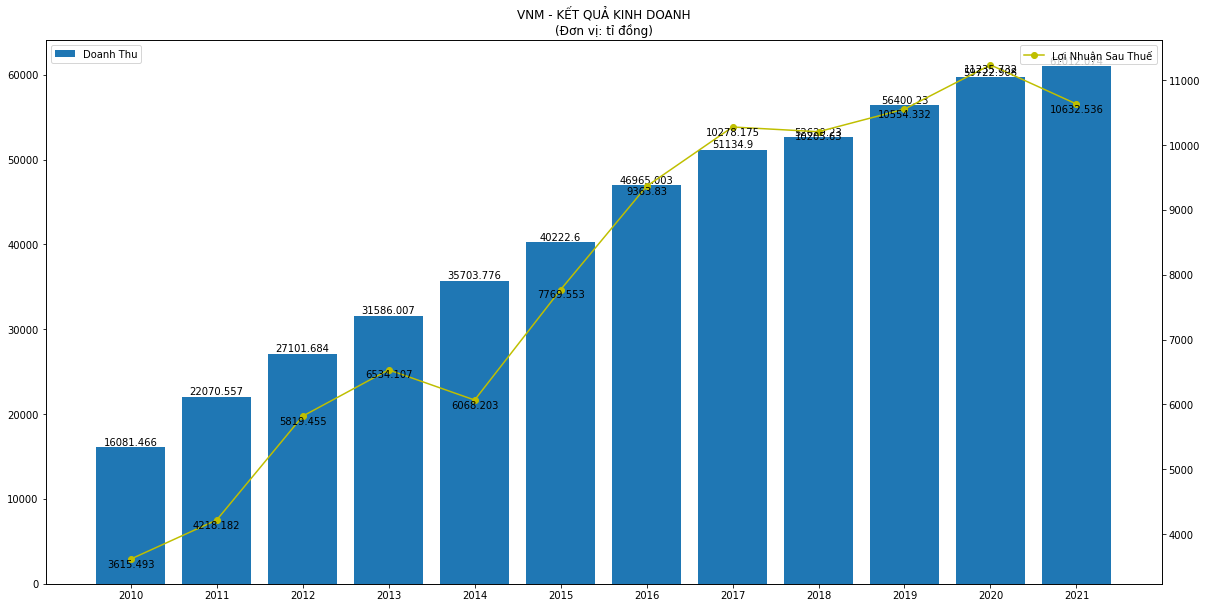

In [13]:
# Vẽ biểu đồ, kết quả hoạt động kinh doanh của dựa trên doanh thu và lợi nhuận
plt.figure(figsize=(20, 10))
plt.bar(headingRows,changeUnit(incomeData, 'IncSta'))
plotData(headingRows, changeUnit(incomeData, 'IncSta'),'bottom')
plt.legend(['Doanh Thu'],loc=2)
plt.twinx()
plt.plot(headingRows, changeUnit(profitData, 'IncSta'), color='y', marker='o')
plotData(headingRows, changeUnit(profitData, 'IncSta'), 'top')
plt.legend(['Lợi Nhuận Sau Thuế'],loc=1)
plt.title(stockSymbol+' - KẾT QUẢ KINH DOANH\n(Đơn vị: tỉ đồng)')
plt.show()

2.2. Structure of total assets of this company in each quarter

In [14]:
# Hàm lấy các thông số từ bảng cân đối kế toán
def crawCDKTDataFromStockSymbol(symbol,heading):
  headingL = []
  dataL = []
  for year in range(int(heading), 2022):
    URL = 'https://s.cafef.vn/bao-cao-tai-chinh/'+symbol+'/BSheet/'+str(year)+'/4/0/0/ket-qua-hoat-dong-kinh-doanh-cong-ty-co-phan-sua-viet-nam.chn'
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, 'html.parser')
    table = soup.find_all('table', attrs={'id':'tableContent'})
    table1 = soup.find_all('table', attrs={'id':'tblGridData'})
    
    for i in table1:
      r = i.find_all('td', attrs={'class':'h_t'})
      r = [r1.text.strip() for r1 in r]
      headingL.append([d for d in r])

    for i in table:
      r = i.find_all('td', attrs={'class':'b_r_c'})
      r = [r1.text.strip() for r1 in r]
      dataL.append([d for d in r])
  data = []
  for d in dataL:
    data.append([d[x:x+6] for x in range(0, len(d), 6)])
  return (headingL, data)

In [15]:
# craw dữ liệu
headingL, data = crawCDKTDataFromStockSymbol(stockSymbol,headingForBSheet[0])
headingForBSheet = [str(i) for i in range(int(headingForBSheet[0]), 2022)]

In [16]:
# Ghi dữ liệu vừa đọc vào file
writeDataCSV(stockSymbol, 'BSheet', 'Cân đối kế toán/')

In [17]:
# Đọc dữ liệu từ file ra để lưu các giá trị cho việc vẽ biểu đồ
# Dự liệu được lấy từ file đã lưu vì việc truy vấn đến dễ hơn là lây dữ liệu khi craw để vẽ
# Chỉ sử dụng dữ liệu 4 năm (16 quý) gần đây để vẽ biểu đồ, để biểu đồ trong đẹp và dễ quan sát hơn
listOfFile = []
path = '/content/Cân đối kế toán'
for filename in glob.glob(os.path.join(path, '*.csv')):
  listOfFile.append(filename)

cdkt = headingForBSheet[-4:]

def readSpecialData(num, cdkt):
  cdktR = []
  for c, y in zip(cdkt[len(cdkt)-num:], cdkt[len(cdkt)-num:]):
    c = pd.read_csv('/content/Cân đối kế toán/'+stockSymbol+'-CDKT-'+y+'.csv')
    cdktR.append(c)
  return cdktR
if len(listOfFile) >= 4:
  cdkt = readSpecialData(4, cdkt)
else:
  if len(listOfFile) == 3:
    cdkt = readSpecialData(3, cdkt)
  elif len(listOfFile) == 2:
    cdkt = readSpecialData(2, cdkt)
  else:
    cdkt = readSpecialData(1, cdkt)



In [18]:
# Lưu các dữ liệu cần thiết vào các dictionary, tùy theo loại chứng khoán
data1 = {}
data2 = {}
data3 = {}
data4 = {}
data5 = {}
data6 = {}
data7 = {}
data8 = {}
data9 = {}
data10 = {}
if checkType(stockSymbol) == ('r_item_a','80','r_item_a','200'):
  for c in cdkt:
    data1.update(c.iloc[1][1:])
    data2.update(c.iloc[2][1:])
    data3.update(c.iloc[8][1:])
    data4.update(c.iloc[21][1:])
    data5.update(c.iloc[24][1:])
    data6.update(c.iloc[28][1:])
    data7.update(c.iloc[29][1:])
    data8.update(c.iloc[34][1:])
    data9.update(c.iloc[45][1:])
    data10.update(c.iloc[54][1:])
  para = ['Tiền mặt và các khoản tương đương tại quỹ',' Tiền gửi tại NHNN','Cho vay khách hàng','Chứng khoán kinh doanh','Chứng khoán đầu tư','Các công cụ tài chính phái sinh','Góp vốn, đầu tư dài hạn','Tài sản cố định',' Bất động sản đầu tư','Tài sản Có khác']
else:
  for c in cdkt:
    data1.update(c.iloc[4][1:])
    data2.update(c.iloc[8][1:])
    data3.update(c.iloc[10][1:])
    data4.update(c.iloc[12][1:])
    data5.update(c.iloc[17][1:])
    data6.update(c.iloc[27][1:])
    data7.update(c.iloc[35][1:])
    data8.update(c.iloc[50][1:])
    data9.update(c.iloc[51][1:])
    data10.update(c.iloc[57][1:])
  para = ['Các khoản đầu tư tài chính ngắn hạn', 'Các khoản phải thu ngắn hạn', 'Trả trước cho người bán', 'Phải thu theo tiến độ', 'Hàng tồn kho', 'Các khoản phải thu dài hạn', 'Tài sản cố định', 'Chi phí xây dựng cơ bản dở dang', 'Đầu tư tài chính dài hạn', 'Tài sản dài hạn khác']
# print(cdkt[0]) 4 8 10 12 17 27 35 50 51 61


In [19]:
# Thay đổi dữ liệu về đơn vị tỷ đồng, do không hiển thị lên biểu đồ nên không làm tròn dữ liệu
# def changeData(data):
#   dataC = []
#   for i in data.values():
#     if str(i) != 'nan':
#       dataC.append(float(str(i).replace(',','')))
#     else:
#       dataC.append(0)
#   bilionD = []
#   for m in dataC:
#     bilionD.append(m/1000000000)
#   return bilionD

In [20]:
# Thay đổi các giá trị về đơn vị tỷ đồng
valueD1 = changeUnit(data1, 'BSheet')
valueD2 = changeUnit(data2, 'BSheet')
valueD3 = changeUnit(data3, 'BSheet')
valueD4 = changeUnit(data4, 'BSheet')
valueD5 = changeUnit(data5, 'BSheet')
valueD6 = changeUnit(data6, 'BSheet')
valueD7 = changeUnit(data7, 'BSheet')
valueD8 = changeUnit(data8, 'BSheet')
valueD9 = changeUnit(data9, 'BSheet')
valueD10 = changeUnit(data10, 'BSheet')

In [21]:
print(valueD1)
print(valueD2)
print(valueD3)
print(valueD4)
print(valueD5)
print(valueD6)
print(valueD7)
print(valueD8)
print(valueD9)
print(valueD10)

[9661.889566014, 0.0, 7772.300444146, 8673.92695189, 9666.846652579, 9306.531479431, 10238.285848104, 12435.744328964, 14370.28860853, 16363.06073834, 17872.002664622, 17313.679774893, 19542.794237097, 19971.22271051, 19753.142693943, 21025.735779475]
[5175.991528051, 0.0, 5460.673084444, 4639.447900101, 5520.731708608, 5391.295160818, 5699.702616339, 4503.154728959, 4711.713537853, 5674.690836392, 5976.863349617, 5187.25317215, 5320.350430335, 6370.305908925, 6118.496933219, 5822.028742791]
[696.32034539, 0.0, 793.597136008, 876.158254325, 824.642255092, 764.793333218, 760.510957858, 576.013061394, 388.901000559, 540.579362752, 475.798169117, 546.236562342, 653.239283565, 976.845401593, 866.059864322, 655.822646219]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[4373.067721747, 0.0, 4320.172955926, 5525.845959354, 5353.836025138, 5540.929744702, 4990.634977666, 4983.044403917, 5733.793403343, 5696.221872518, 5246.489877728, 4905.068613616, 6465.94310

In [22]:
# Tính toán vị trị xếp chồng của các thông số
def getPoBottom(list1, list2):
  return [value1+value2 for value1,value2 in zip(list1, list2)]


In [23]:
b2 = getPoBottom(valueD1,valueD2)
b3 = getPoBottom(b2,valueD3)
b4 = getPoBottom(b3,valueD4)
b5 = getPoBottom(b4,valueD5)
b6 = getPoBottom(b5,valueD6)
b7 = getPoBottom(b6,valueD7)
b8 = getPoBottom(b7,valueD8)
b9 = getPoBottom(b8,valueD9)


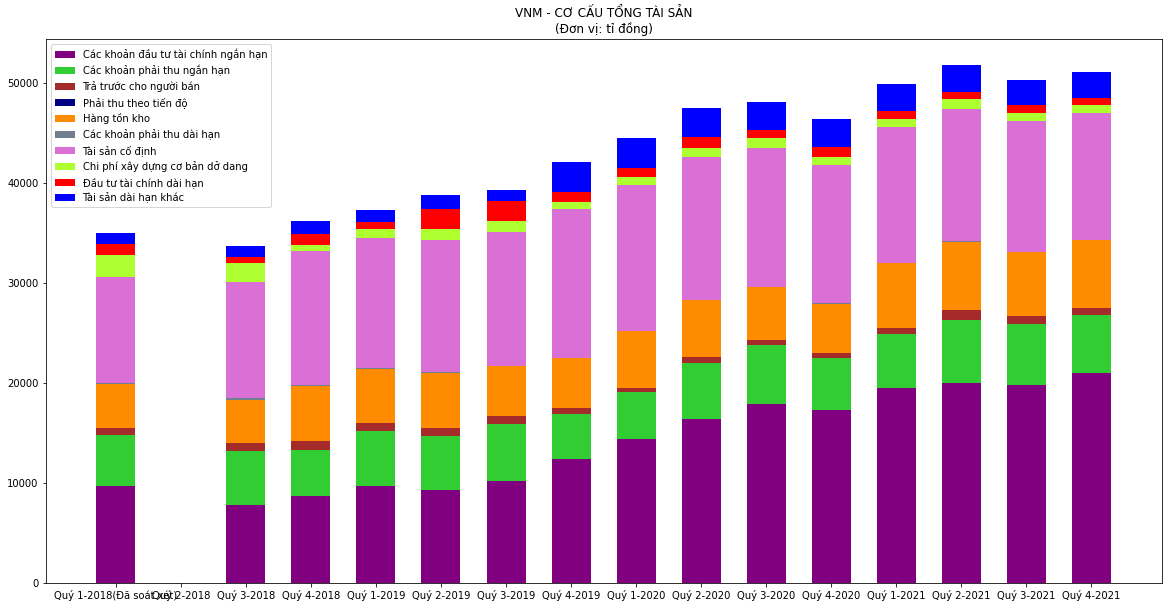

In [24]:
# Vẽ biểu đồ cơ cấu tổng tài sản của công ty
plt.figure(figsize=(20, 10))
plt.bar(data1.keys(),valueD1,width=0.6, bottom=0,color='#800080')
plt.bar(data2.keys(),valueD2,width=0.6, bottom=valueD1,color='#32CD32')
plt.bar(data3.keys(),valueD3,width=0.6, bottom=b2,color='#A52A2A')
plt.bar(data4.keys(),valueD4,width=0.6, bottom=b3,color='#000080')
plt.bar(data5.keys(),valueD5,width=0.6, bottom=b4,color='#FF8C00')
plt.bar(data6.keys(),valueD6,width=0.6, bottom=b5,color='#708090')
plt.bar(data7.keys(),valueD7,width=0.6, bottom=b6,color='#DA70D6')
plt.bar(data8.keys(),valueD8,width=0.6, bottom=b7,color='#ADFF2F')
plt.bar(data9.keys(),valueD9,width=0.6, bottom=b8,color='#FF0000')
plt.bar(data10.keys(),valueD10,width=0.6, bottom=b9,color='#0000FF')

plt.title(stockSymbol+' - CƠ CẤU TỔNG TÀI SẢN\n(Đơn vị: tỉ đồng)')
plt.legend(para)
plt.show()